In [1]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern, RBF
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat
import numpy as np

os.chdir("../../")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace
from src.acquisition import run_acquisition
from src.algorithms import MultiRegionSetUnion, MultiRegionSetIntersection, GlobalOptimization1D, ParetoFront, Wishlist, PercentileSet
from src.models import MGPR, fit_hypers
from src.metrics import get_n_obtained, get_jaccard_posterior
from src.plotting import plot_final_metrics, plot_iteration_results, plot_algo_true_function
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


Load / download datasets

In [2]:
data = loadmat('datasets/FeCoNi_benchmark_dataset_220501a.mat')
X = data['C'][:,0:2] # only need 2 dimensions of composition since c3 = c2 + c1 
Y1 = data['Coer'] # magnetic property 1 
Y2 = data['Kerr'] # magnetic property 2 
Y = np.hstack((Y1, Y2))
n_features, n_properties = X.shape[1], Y.shape[1]

print("Size of the design space: {}, Size of the measured property space: {}".format(X.shape, Y.shape))

Size of the design space: (921, 2), Size of the measured property space: (921, 2)


Normalize datasets (in order to get GP models to fit well)

In [3]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

X_unnorm, Y_unnorm = x_scaler.inverse_transform(X), y_scaler.inverse_transform(Y)


[  6   7   8  49  64 144 145 146 147 148 149 150 151 152 153 154 198 200
 207 696 699 700 701 702 721 723 740 741 742 743 744 760 763 764 798 814
 815 829 830 834]


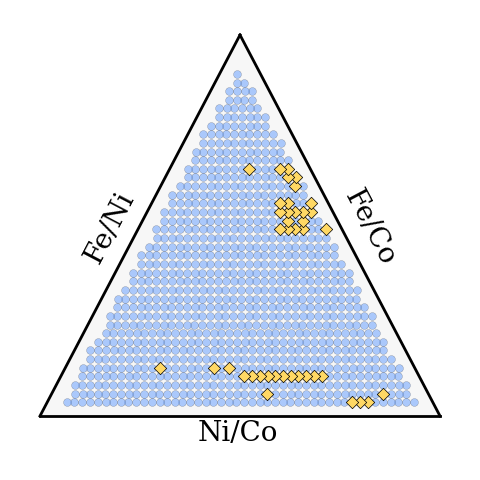

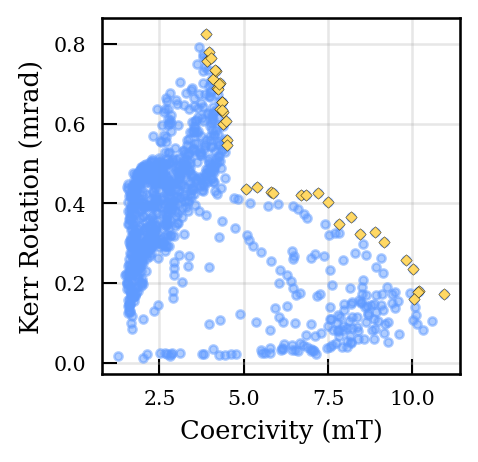

In [4]:
# algorithm = Wishlist(
#     threshold_bounds=[[[0.0, 10.0], [0.0, 1.0]]], scalers=scalers
# )


# this is a variant of a pareto front which allows for robustness for each property [0.00001, 0.00001] will give a traditional pareto front; experiment with increasing!
algorithm = ParetoFront(tolerance_list = [0.01, 0.01],  max_or_min_list = [1, 1], scalers = scalers)

plot_algo_true_function(algorithm, X_unnorm, Y_unnorm)
# algorithm = PercentileSet(percentile_threshold=95, scalers=scalers)


In [5]:
all_ids = list(np.arange(0, len(X)))  # integer mapping design space
true_target_ids = algorithm.identify_subspace(x=X, y=Y) 

In [6]:
plotting = True
prevent_requery = True
plot_frequency = 200
n_posterior_samples = 15 # relevant for InfoBAX and mixedBAX 
n_initial = 1 # Number of initial datapoints 
n_iters = 201 # Number of measurements to be performed 
n_repeats = 1 # Repeats with different dataset initializations 
fixed_hypers = True 
adaptive_fit_freq = 10

# GP parameters
kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

In [7]:

metrics = {
    "mixed": {"n_obtained": [], "jaccard_posterior_index": []},
    "meanbax": {"n_obtained": [], "jaccard_posterior_index": []},
    "infobax": {"n_obtained": [], "jaccard_posterior_index": []},
}

# Baseling for random sampling without replacement (expectation of hypergeometric distribution)
random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

# Baseline for best possible acquisition (i.e. acquire a target point at each iteration; need an "oracle" to do this)
if n_iters <= len(true_target_ids):
    best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
else:
    best_possible_n_obtained = list(np.arange(n_initial, len(true_target_ids))) + list(
        len(true_target_ids) * np.ones(n_iters + n_initial - len(true_target_ids))
    )

# Acquisition functions that use BAX for subset estimation
strategies = ["meanbax", "switchbax", "infobax"]

# Calculate hypers based on the entire dataset; this is not possible in a real experiment but allows us to compare acquisition fn to acquisition fn
if fixed_hypers:
    kernel_list = fit_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list, n_restarts_optimizer=5)

for strategy in strategies:
    for j in range(n_repeats):  # to see variance w.r.t initial datapoint choice
        np.random.seed(j+1) # make sure all strategies get same initial points
        train_indices = list(np.random.choice(all_ids, n_initial))
        x_train = X[train_indices]
        y_train = Y[train_indices]

        collected_ids = list(train_indices)
        n_obtained_list = []
        jaccard_posterior_list = []

        for i in tqdm(range(n_iters)):
            # Adaptive hyperparameter fitting
            if (i % adaptive_fit_freq == 0) and (fixed_hypers == False):
                kernel_list = fit_hypers(x_train=x_train, y_train=y_train, kernel_list=kernel_initial_list)
            
            # Define GP model with fixed, fitted hypers. Note, we need this so that all the n_posterior models for InfoBAX have the same kernel
            multi_gpr = MGPR(kernel_list=kernel_list)

            # Acquire next index
            x_train, y_train, model, collected_ids, acquisition_function = run_acquisition(
                x_train, y_train, X, Y, strategy, algorithm, multi_gpr, collected_ids, n_posterior_samples
            )

            # Calculate metrics
            posterior_mean, posterior_std = model.predict(X)
            predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)
            n_obtained_list.append(get_n_obtained(collected_ids, true_target_ids))
            jaccard_posterior_list.append(get_jaccard_posterior(predicted_target_ids, true_target_ids))

            if (i % plot_frequency == 0) and (plotting) and (i != 0):
                plot_iteration_results(
                    X,
                    Y,
                    x_scaler,
                    y_scaler,
                    collected_ids,
                    true_target_ids,
                    predicted_target_ids,
                    acquisition_function,
                    n_obtained_list,
                    jaccard_posterior_list,
                    best_possible_n_obtained,
                    random_sampling,
                )

        metrics[strategy]["n_obtained"].append(n_obtained_list)
        metrics[strategy]["jaccard_posterior_index"].append(jaccard_posterior_list)

plot_final_metrics(n_iters, metrics, strategies, best_possible_n_obtained, random_sampling)

 25%|██▌       | 51/201 [00:01<00:05, 27.03it/s]